<a href="https://colab.research.google.com/github/xelanicol/miniprojects/blob/main/garbage_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive/')
os.chdir('drive/My Drive/')

Mounted at /content/drive/


In [ ]:
#from jupyterthemes import jtplot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Conv2D, Flatten, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
#import zipfile
#with zipfile.ZipFile('garbage_classification.zip', 'r') as zip_ref:
#    zip_ref.extractall('garbage_classification')

In [ ]:
def rescale_func(x,xmin=0,xmax=255):
  x = (x-xmin)/(xmax-xmin)
  x = 2*x - 1
  return x.astype(np.float32)

val_split = 0.1 
train_IDG = ImageDataGenerator(    
    rotation_range = 180,
    width_shift_range = 0.1,
    height_shift_range = 0.1, 
    brightness_range = (0.9,1.1),
    #shear_range = 20,
    #zoom_range = 0.2,
    fill_mode = 'constant',
    cval = 255,
    #channel_shift_range = 64,# before rescale/preprocessing
    horizontal_flip = True,
    vertical_flip = True,
    validation_split =val_split,
    preprocessing_function = rescale_func
)
val_IDG = ImageDataGenerator(    
    validation_split = val_split,
    preprocessing_function = rescale_func
)
traingen = train_IDG.flow_from_directory( 'garbage_classification/Garbage classification/Garbage classification', subset='training')
valgen = val_IDG.flow_from_directory('garbage_classification/Garbage classification/Garbage classification', subset='validation', shuffle=False )
assert(valgen.filenames not in traingen.filenames)

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


In [ ]:
print(traingen.class_indices)

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


In [ ]:
Xeg, yeg = traingen.next()
print('X min, max, mean, type, shape:',Xeg.min(), Xeg.max(), Xeg.mean(), Xeg.dtype,Xeg.shape)
print('y min, max, mean, type, shape:',yeg.min(), yeg.max(), yeg.mean(), yeg.dtype,yeg.shape)

X min, max, mean, type, shape: -1.0 1.0 0.33535603 float32 (32, 256, 256, 3)
y min, max, mean, type, shape: 0.0 1.0 0.16666667 float32 (32, 6)


In [ ]:
ip = Input(Xeg.shape[1:],)
x = Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu')(ip)
x = Dropout(0.1)(x)
x = Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
x = Dropout(0.1)(x)
x = Conv2D(filters=128, kernel_size=3, strides=2, padding='same', activation='relu')(x)
x = Dropout(0.1)(x)
x = Conv2D(filters=256, kernel_size=3, strides=2, padding='same', activation='relu')(x)
x = Dropout(0.1)(x)
x = Conv2D(filters=512, kernel_size=3, strides=2, padding='same', activation='relu')(x)
x = Dropout(0.1)(x)
x = Flatten()(x)
x = Dense(6, activation='softmax')(x)
model = Model(ip,x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 128)       0     

In [ ]:
model.compile(Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
 from keras.callbacks import EarlyStopping
H = model.fit(traingen, batch_size=64, epochs = 100, validation_data = valgen,
)#callbacks=[EarlyStopping('val_loss',patience=5)]

Epoch 1/100
72/72 [==============================] - 1085s 15s/step - loss: 1.7189 - accuracy: 0.2437 - val_loss: 1.5669 - val_accuracy: 0.3745
Epoch 2/100
72/72 [==============================] - 42s 576ms/step - loss: 1.5455 - accuracy: 0.4001 - val_loss: 1.5469 - val_accuracy: 0.3506
Epoch 3/100
72/72 [==============================] - 42s 578ms/step - loss: 1.4767 - accuracy: 0.4052 - val_loss: 1.4812 - val_accuracy: 0.3825
Epoch 4/100
72/72 [==============================] - 42s 582ms/step - loss: 1.4277 - accuracy: 0.4353 - val_loss: 1.4493 - val_accuracy: 0.4263
Epoch 5/100
72/72 [==============================] - 41s 575ms/step - loss: 1.3364 - accuracy: 0.4707 - val_loss: 1.3918 - val_accuracy: 0.4143
Epoch 6/100
72/72 [==============================] - 41s 573ms/step - loss: 1.3128 - accuracy: 0.4851 - val_loss: 1.3384 - val_accuracy: 0.4303
Epoch 7/100
72/72 [==============================] - 41s 573ms/step - loss: 1.2476 - accuracy: 0.5035 - val_loss: 1.3466 - val_accuracy:

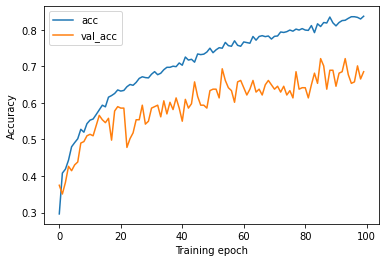

In [ ]:
plt.plot(H.history['accuracy'],label='acc')
plt.plot(H.history['val_accuracy'],label='val_acc')
plt.xlabel('Training epoch')
plt.ylabel('Accuracy')
plt.legend();

In [ ]:
from keras.models import save_model,load_model
save_model(model,'garbage_cat.h5')

In [ ]:
model = load_model('garbage_cat.h5')

In [ ]:
valgen.reset()
Xval = []
yval = []
for _ in range(np.ceil(valgen.n/valgen.batch_size).astype(int)):
  a,b = valgen.next()
  Xval.append(a)
  yval.append(b)
Xval = np.concatenate(Xval,axis=0)
yval = np.concatenate(yval,axis=0)
print(Xval.shape, yval.shape)
 
i2c = {v:k for k,v in valgen.class_indices.items()}
pred = model.predict( Xval )

(251, 256, 256, 3) (251, 6)


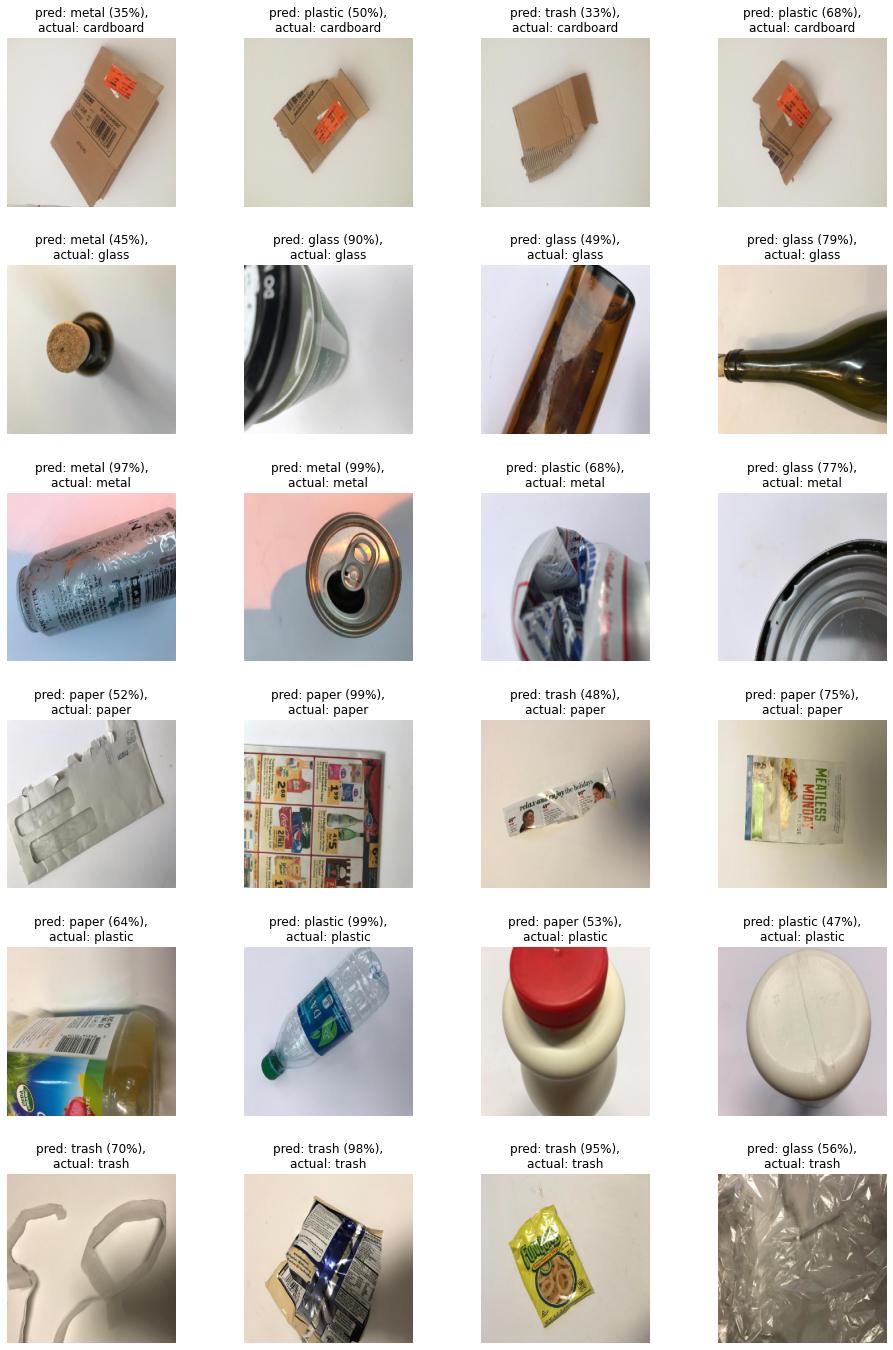

In [ ]:
plt.figure(figsize=(16,24))
for i in valgen.class_indices.values():
  idx = np.argwhere(valgen.classes==i)[-4:]
  truclass = i2c[i]
  for j, k in enumerate(idx):
    plt.subplot(6,4,i*4 + j + 1)
    plt.imshow((Xval[k][0]+1)/2)
    predclass = i2c[np.argmax(pred[k])]
    plt.title('pred: %s (%d%%),\nactual: %s'%(predclass,pred[k].max()*100,truclass))
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=0.35)

Overall validation accuracy: 68.5%
Overall ROC_AUC score: 0.94


,precision,recall,f1-score,support,class accuracy
cardboard,0.871,0.675,0.761,40.000,0.675
glass,0.661,0.820,0.732,50.000,0.820
metal,0.692,0.659,0.675,41.000,0.659
paper,0.676,0.814,0.738,59.000,0.814
plastic,0.594,0.396,0.475,48.000,0.396
trash,0.625,0.769,0.690,13.000,0.769
accuracy,0.685,0.685,0.685,0.685,NaN
macro avg,0.687,0.689,0.678,251.000,NaN
weighted avg,0.688,0.685,0.677,251.000,NaN


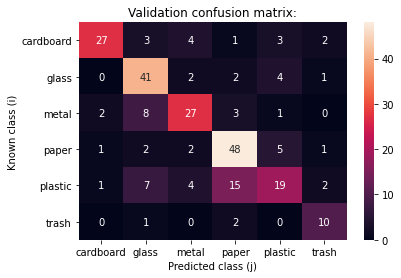

In [ ]:
pd.set_option("precision", 3)
tru = valgen.classes
pred = model.predict(valgen)
print('Overall validation accuracy: %.1f%%'%((tru==np.argmax(pred,axis=1)).mean() *100))
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
print('Overall ROC_AUC score: %.2f'%roc_auc_score(tru,pred,multi_class='ovo'))
import seaborn as sns
cm = confusion_matrix(tru,np.argmax(pred,axis=1))
sns.heatmap(
    cm,
    annot=True, xticklabels=valgen.class_indices.keys(), 
    yticklabels=valgen.class_indices.keys());
plt.title('Validation confusion matrix:')
plt.xlabel('Predicted class (j)')
plt.ylabel('Known class (i)')
res = pd.DataFrame().from_dict(classification_report( tru,np.argmax(pred,axis=1),output_dict=True)).T
res.rename(index={str(k):v for k,v in i2c.items()},inplace=True)
res.loc[:'trash','class accuracy'] = np.diag(cm) / np.sum(cm,axis=1)
display(res)

In [ ]:
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

In [ ]:
vgg16 = VGG16(
    include_top = False,
    weights = 'imagenet',
    input_tensor = ip,
    pooling = None,
)
vgg16.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
______________________________________________________________

In [ ]:
for layer in vgg16.layers:
  layer.trainable = False
x = Flatten()(vgg16.output)
x = Dense(6,activation='softmax')(x)
vgg_model = Model(vgg16.input,x)
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0   

In [ ]:
vgg_model.compile(Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
val_split = 0.1
train_IDG = ImageDataGenerator(
    rotation_range = 180,
    width_shift_range = 0.1,
    height_shift_range = 0.1, 
    brightness_range = (0.9,1.1),
    #shear_range = 20,
    #zoom_range = 0.2,
    fill_mode = 'constant',
    cval = 255,
    #channel_shift_range = 64,# before rescale/preprocessing
    horizontal_flip = True,
    vertical_flip = True,
    validation_split =val_split,
    preprocessing_function = preprocess_input
)
val_IDG = ImageDataGenerator(
    validation_split = val_split,
    preprocessing_function = preprocess_input
)
traingen = train_IDG.flow_from_directory('garbage_classification/Garbage classification/Garbage classification', subset='training')
valgen = val_IDG.flow_from_directory('garbage_classification/Garbage classification/Garbage classification', subset='validation', shuffle=False )
assert(valgen.filenames not in traingen.filenames)

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


In [ ]:
H = vgg_model.fit(traingen, batch_size=64, epochs = 50, validation_data = valgen,
)

Epoch 1/50
72/72 [==============================] - 49s 652ms/step - loss: 7.9091 - accuracy: 0.3303 - val_loss: 4.1824 - val_accuracy: 0.5458
Epoch 2/50
72/72 [==============================] - 44s 616ms/step - loss: 3.5416 - accuracy: 0.6051 - val_loss: 3.6087 - val_accuracy: 0.6056
Epoch 3/50
72/72 [==============================] - 44s 614ms/step - loss: 2.7819 - accuracy: 0.6657 - val_loss: 3.4781 - val_accuracy: 0.6375
Epoch 4/50
72/72 [==============================] - 45s 617ms/step - loss: 2.2265 - accuracy: 0.7051 - val_loss: 2.8314 - val_accuracy: 0.6813
Epoch 5/50
72/72 [==============================] - 44s 614ms/step - loss: 2.0562 - accuracy: 0.7417 - val_loss: 2.8672 - val_accuracy: 0.6733
Epoch 6/50
72/72 [==============================] - 44s 623ms/step - loss: 1.9911 - accuracy: 0.7536 - val_loss: 2.3855 - val_accuracy: 0.7331
Epoch 7/50
72/72 [==============================] - 44s 612ms/step - loss: 1.5328 - accuracy: 0.7908 - val_loss: 2.2420 - val_accuracy: 0.7131

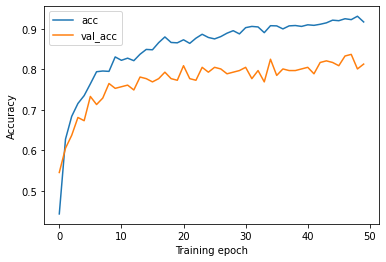

In [ ]:
plt.plot(H.history['accuracy'],label='acc')
plt.plot(H.history['val_accuracy'],label='val_acc')
plt.xlabel('Training epoch')
plt.ylabel('Accuracy')
plt.legend();

In [ ]:
from keras.models import save_model,load_model
save_model(vgg_model,'garbage_cat_vgg16.h5')

In [ ]:
valgen.reset()
Xval = []
yval = []
for _ in range(np.ceil(valgen.n/valgen.batch_size).astype(int)):
  a,b = valgen.next()
  Xval.append(a)
  yval.append(b)
Xval = np.concatenate(Xval,axis=0)
yval = np.concatenate(yval,axis=0)
print(Xval.shape, yval.shape)
 
i2c = {v:k for k,v in valgen.class_indices.items()}
pred = vgg_model.predict( Xval )

(251, 256, 256, 3) (251, 6)


Overall validation accuracy: 81%
Overall ROC_AUC score: 0.97


,precision,recall,f1-score,support
cardboard,0.971,0.850,0.907,40.000
glass,0.861,0.620,0.721,50.000
metal,0.717,0.927,0.809,41.000
paper,0.898,0.898,0.898,59.000
plastic,0.709,0.812,0.757,48.000
trash,0.692,0.692,0.692,13.000
accuracy,0.813,0.813,0.813,0.813
macro avg,0.808,0.800,0.797,251.000
weighted avg,0.826,0.813,0.812,251.000


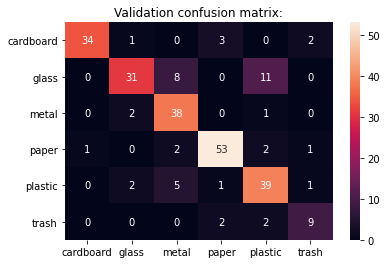

In [ ]:
tru = valgen.classes
pred = vgg_model.predict(valgen)
print('Overall validation accuracy: %d%%'%((tru==np.argmax(pred,axis=1)).mean() *100))
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
print('Overall ROC_AUC score: %.2f'%roc_auc_score(tru,pred,multi_class='ovo'))
import seaborn as sns
sns.heatmap(
    confusion_matrix(tru,np.argmax(pred,axis=1)),
    annot=True, xticklabels=valgen.class_indices.keys(), 
    yticklabels=valgen.class_indices.keys());
plt.title('Validation confusion matrix:')
res = pd.DataFrame().from_dict(classification_report( tru,np.argmax(pred,axis=1),output_dict=True)).T
display(res.rename(index={str(k):v for k,v in i2c.items()}))